In [1]:
import pandas as pd
import numpy as np
import nltk
from HanTa import HanoverTagger as ht
import string
from tqdm.auto import tqdm
import top2vec
import pickle
import spacy
import mgzip
from nltk.tokenize import sent_tokenize
from pandarallel import pandarallel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import pyreadr
from bertopic import BERTopic

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Topic modeling
## Option 1: top2vec
Creates unique topics for each article, as feature for the comment prediction. Has to be run with speed='learn' / 'deep-learn' properly.

In [39]:
# full text, not preprocessed
docs = combined_news.combined_text.to_list()

NameError: name 'combined_news' is not defined

In [97]:
model = top2vec.Top2Vec(docs, speed="fast-learn", ngram_vocab=True, ngram_vocab_args={'min_count':50,'threshold':50.0,'connector_words':frozenset("der die das".split()),'scoring':'npmi'})

2022-06-09 14:00:33,300 - top2vec - INFO - Pre-processing documents for training
2022-06-09 14:00:53,281 - top2vec - INFO - Creating joint document/word embedding


ValueError: threshold should be between -1 and 1 for npmi scoring

In [65]:
# save model in order to save on computation time
model.save('../models/topic2vec_fastlearn_ngram.t2v')

In [15]:
model = top2vec.Top2Vec(list(test['combined_text']), speed="fast-learn")

2022-06-09 14:27:27,828 - top2vec - INFO - Pre-processing documents for training
2022-06-09 14:27:59,326 - top2vec - INFO - Creating joint document/word embedding
2022-06-09 15:01:30,446 - top2vec - INFO - Creating lower dimension embedding of documents
2022-06-09 15:02:01,141 - top2vec - INFO - Finding dense areas of documents
2022-06-09 15:02:02,592 - top2vec - INFO - Finding topics


In [16]:
# save model in order to save on computation time
model.save('../models/topic2vec_fastlearn_full.t2v')

In [60]:
# preprocessed text
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [61]:
# load precomputed model; args used: min_count=50, speed="fast-learn", ngram_vocab=False, workers=18, embedding_model='universal-sentence-encoder-multilingual'
model = top2vec.Top2Vec.load('../models/topic2vec_fastlearn_full.t2v')

Look at unreduced topics, found by unsupervised machine learning

In [62]:
num_of_topics = model.get_num_topics(reduced=False)

In [63]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=False)

In [64]:
topic_words, word_scores, topic_nums = model.get_topics(num_of_topics, reduced=False)

In [65]:
topic_nums, topic_score, topics_words, word_scores = model.get_documents_topics(list(combined_news_pre.index), reduced=False, num_topics=2)

Reduce the models to 21, according to the percentage size of the topics

In [67]:
topic_percent = pd.DataFrame()
topic_percent['sizes'] = topic_sizes
topic_percent['percent'] = topic_percent['sizes']/sum(topic_percent['sizes'])
topic_percent['percent']

0      0.034046
1      0.027750
2      0.023987
3      0.022897
4      0.020751
         ...   
190    0.000950
191    0.000914
192    0.000739
193    0.000703
194    0.000668
Name: percent, Length: 195, dtype: float64

In [8]:
model.hierarchical_topic_reduction(7)

[[65,
  10,
  100,
  165,
  45,
  87,
  9,
  74,
  23,
  64,
  157,
  118,
  184,
  172,
  192,
  111,
  180,
  124,
  181,
  37,
  79,
  125,
  25,
  133,
  29,
  91,
  51,
  18,
  136,
  33,
  86,
  113,
  4],
 [110,
  134,
  148,
  19,
  50,
  153,
  121,
  68,
  154,
  127,
  156,
  151,
  178,
  138,
  120,
  49,
  57,
  146,
  150,
  99,
  179,
  52,
  44,
  171,
  102,
  77,
  166,
  24,
  5,
  190,
  48,
  145,
  185,
  105,
  152,
  101,
  88,
  159,
  12,
  170,
  128,
  115,
  188,
  193,
  7,
  58,
  15,
  176,
  13,
  144,
  177,
  182,
  26,
  98,
  60,
  119,
  3],
 [31, 73, 8, 174, 27, 94, 11, 62, 137, 34, 70, 28, 46, 47, 186, 0],
 [81,
  173,
  1,
  17,
  56,
  66,
  123,
  103,
  106,
  164,
  112,
  155,
  96,
  160,
  72,
  39,
  163,
  55,
  122,
  71,
  143,
  183,
  114,
  84,
  167,
  141,
  147,
  149,
  162,
  169,
  194,
  21],
 [131,
  191,
  80,
  117,
  16,
  140,
  20,
  42,
  22,
  189,
  69,
  126,
  35,
  130,
  139,
  132,
  38,
  95,
  93,
  142,
  1

In [9]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=True)
topics_words, words_scores, topics_nums = model.get_topics(reduced=True)
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(list(combined_news_pre.index), reduced=True, num_topics=2)

In [10]:
topic_nums

array([[0, 4],
       [5, 4],
       [6, 2],
       ...,
       [5, 1],
       [6, 4],
       [6, 1]])

In [22]:
topics_words

array([['mir', 'meine', 'meinem', 'plotzlich', 'meinen', 'ja',
        'freundin', 'mein', 'manchmal', 'kuche', 'freunde', 'vielleicht',
        'meiner', 'freundinnen', 'gefuhl', 'mich', 'erzahlen', 'paar',
        'gedanken', 'irgendwie', 'gekocht', 'mal', 'trainierenteil',
        'mutter', 'dir', 'bisschen', 'mag', 'zeitmagazin', 'ich', 'was',
        'gluck', 'alles', 'du', 'dachte', 'zwiebel', 'einfach',
        'draußen', 'bloß', 'musik', 'spazieren', 'buch', 'lieder',
        'irgendwann', 'eben', 'nie', 'etwas', 'freunden', 'uns',
        'eigentlich', 'denken'],
       ['bundesliga', 'fußball', 'mannschaft', 'fc', 'trainer',
        'spieltag', 'soder', 'bundesligisten', 'liga', 'borussia',
        'saison', 'spieler', 'pokal', 'csu', 'cdu', 'demonstration',
        'klub', 'spiel', 'hertha', 'unions', 'sport', 'klubs',
        'bundesligist', 'heimspiel', 'dfl', 'sportdirektor', 'markus',
        'startelf', 'beschluss', 'klassenerhalt', 'laschet',
        'verordnung', 'lea

Looking at wordclouds of reduced topics to find topic name, conculsion

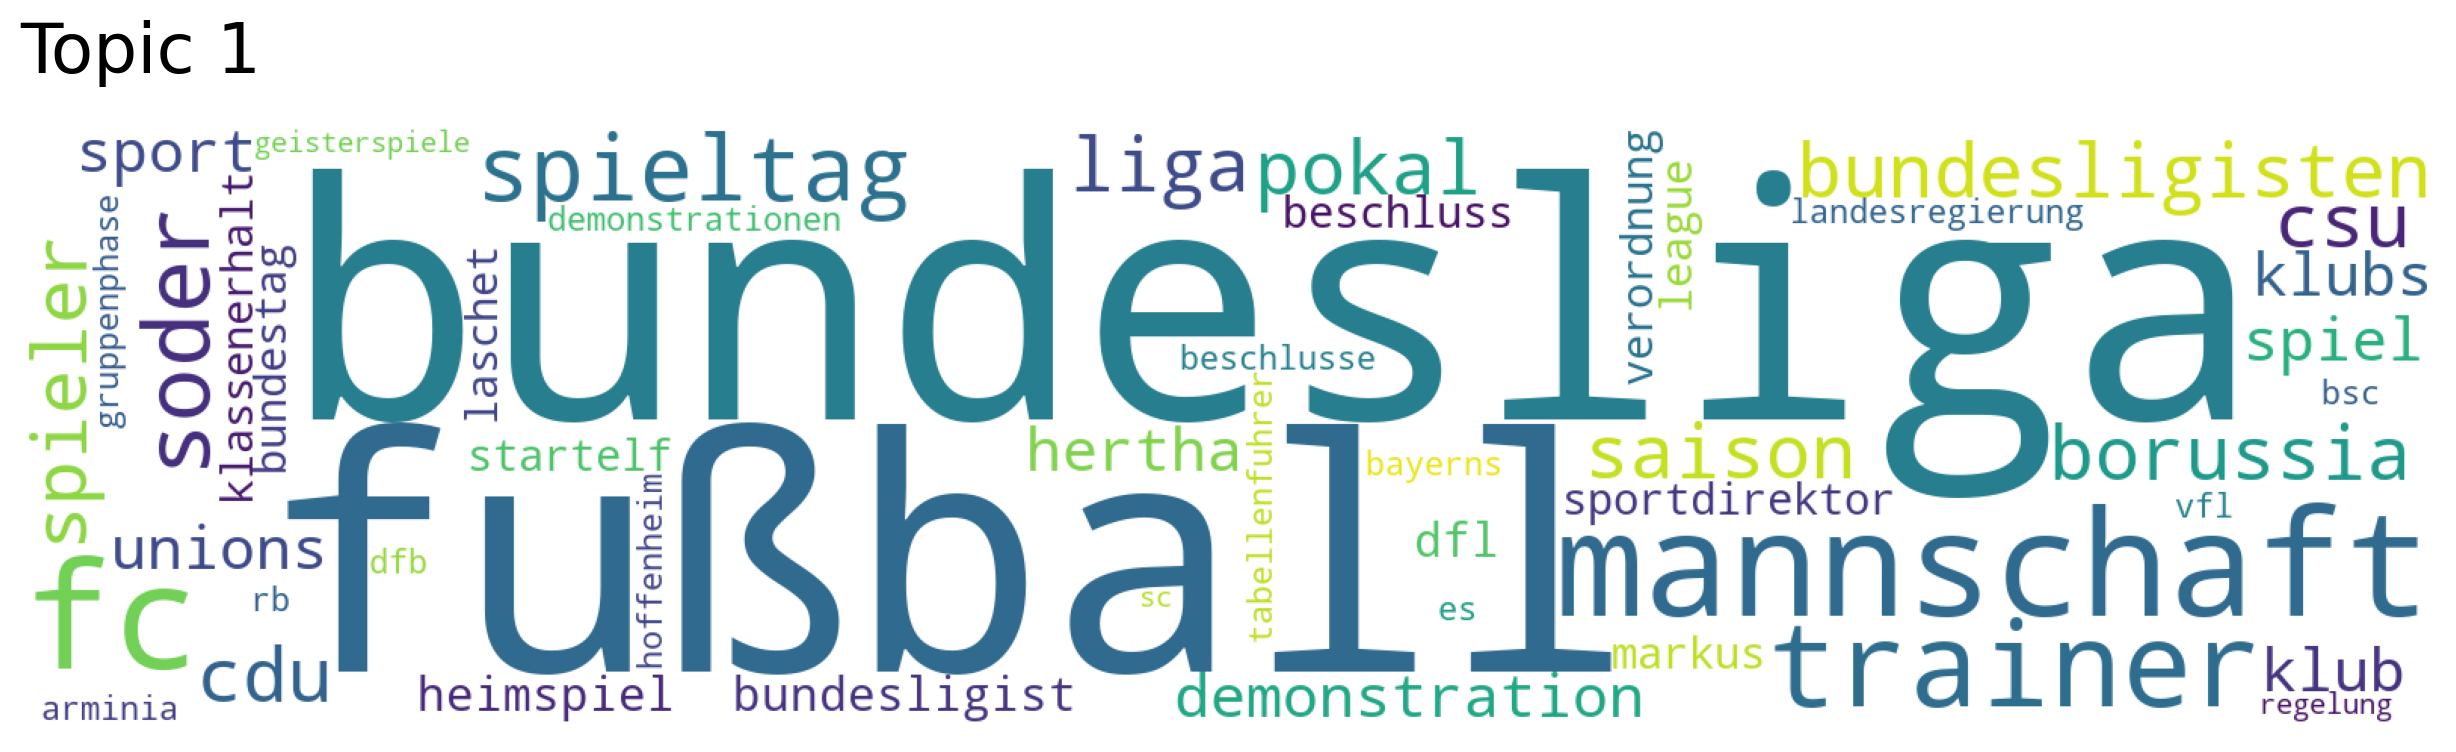

In [23]:
model.generate_topic_wordcloud(1, background_color='white', reduced=True)

In [24]:
label_dict = {0: 'Pandemiepolitik', 1: 'Regionalpolitik', 2: 'Populismus', 3: 'Infektionen', 4: 'Impfung', 5: 'Migration', 6: 'Finanzkrise'}

In [25]:
reduced_labels = model.doc_top_reduced

In [54]:
reduced_labels = np.vectorize(label_dict.get)(reduced_labels)

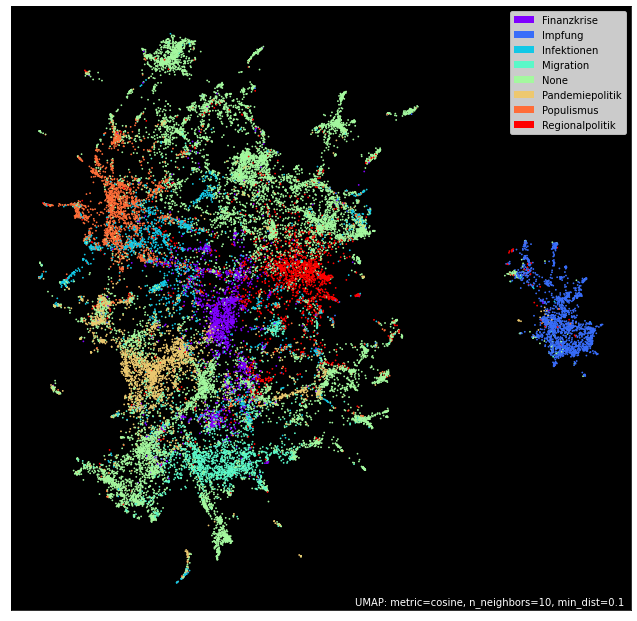

In [55]:
import umap.plot
umap_args_model = {"n_neighbors": 10, "n_components": 2, "metric": "cosine", 'min_dist':0.10, 'spread':1}
umap_model = umap.UMAP(**umap_args_model).fit(model.document_vectors)
umap_fig2 = umap.plot.points(umap_model, labels = reduced_labels, theme='fire')

## Option 2: BERTopic

In [58]:
topic_model = BERTopic(language="German", verbose=True, n_gram_range=(1,2), nr_topics='auto')

In [2]:
# preprocessed text
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [43]:
docs = combined_news_pre.combined_text_joined.to_list()

In [33]:
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/889 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
topic_model.save("../models/bert_reduced.bt")

In [59]:
topic_model = topic_model.load("../models/bert_reduced.bt")

FileNotFoundError: [Errno 2] No such file or directory: '../models/bert_reduced.bt'

In [7]:
topic_model.get_topic_info()

Topic  Count                                          Name
0       -1  14361                          -1__mensch_jahr_zeit
1        0   1668              0_impfstoff_impfung_impfen_dosis
2        1   1644                           1_spieler_spiel_fc_
3        2   1218                    2_app__apple_herunterladen
4        3    653  3_polizei_demonstration_demonstrant_polizist
..     ...    ...                                           ...
202    201     10   201_wirtschaft_prozent_unternehmen_institut
203    202     10     202_kosack_hossbach_schauspieler_chemnitz
204    203     10    203_gewalt_häuslich gewalt_häuslich_etzold
205    204     10          204_test_000 test_beschluß_bund land
206    205     10                205_rki_melden_zahlen_inzidenz

[207 rows x 3 columns]

In [8]:
topic_model.get_topic(0)

[('impfstoff', 0.011989519594472933),
 ('impfung', 0.007491975467219511),
 ('impfen', 0.005937364927950005),
 ('dosis', 0.005598263519381892),
 ('', 0.004796116308827525),
 ('astrazeneca', 0.004749518457124935),
 ('million', 0.004062175135322375),
 ('biontech', 0.004046582067562631),
 ('mensch', 0.003462591575239037),
 ('zulassung', 0.00304173546159226)]

In [9]:
topic_model.visualize_barchart()

In [26]:
topics = topic_model.get_topic_info()

In [28]:
new_topics, new_probs = topic_model.reduce_topics(docs, topics, nr_topics=30)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

# Feature engineering

## Average sentence length

In [4]:
def avg_sent_len(input):
    sent_tokenize_list = sent_tokenize(input)
    return sum(len(x.split()) for x in sent_tokenize_list) / len(sent_tokenize_list)

In [6]:
combined_news_pre['avg_length'] = combined_news_pre['combined_text'].progress_apply(avg_sent_len)

  0%|          | 0/28432 [00:00<?, ?it/s]

## Presence of adjectives

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')


In [8]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [27]:
def pos_count(input):
    keywords_adj = ['ADJA', 'ADJD', 'ADV']
    keywords_noun = ['NN']
    count_adj = 0
    count_nn = 0
    count_total = 0
    for word in input:
        count_total += 1
        tag = tagger.analyze(word)[1]
        if tag in keywords_adj:
            count_adj += 1
        if tag in keywords_noun:
            count_nn += 1
    if count_total == 0:
        count_total = 1
    return count_adj, count_nn, count_adj/count_total, count_nn/count_total

In [29]:
combined_news_pre['pos_count'] = combined_news_pre['text_token'].parallel_apply(pos_count)

In [30]:
combined_news_pre[['count_adj', 'count_nn', 'percent_adj', 'percent_nn']] = pd.DataFrame(combined_news_pre['pos_count'].tolist(), index=combined_news_pre.index)

In [32]:
combined_news_pre.drop('pos_count', axis=1, inplace=True)

## Mention of scientist

In [34]:
def scientist_count(input):
    keywords = ['drosten', 'streeck', 'lauterbach', 'kekulé', 'schmidt-chanasit', 'wodarg']
    scientist = []
    for word in input:
        if word in keywords:
            scientist.append(word)
    return scientist

In [36]:
df_scientists = combined_news_pre['text_token'].apply(scientist_count).str.join('|').str.get_dummies()

## Combine features into one dataframe

In [39]:
combined_news_pre = pd.concat([combined_news_pre, df_scientists], axis=1)

In [43]:
with mgzip.open('../data/combined_news_pre.mgzip', 'wb') as handle:
    pickle.dump(combined_news_pre, handle)

## load saved datasets

In [2]:
# load command
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [3]:
# load command
with mgzip.open('../data/zeit_predict_value.mgzip', 'rb') as handle:
    zeit_predict = pickle.load(handle)

In [4]:
# load command
with mgzip.open('../data/tagesspiegel_predict_value.mgzip', 'rb') as handle:
    tagesspiegel_predict = pickle.load(handle)

In [5]:
# load command
with mgzip.open('../data/welt_predict_value.mgzip', 'rb') as handle:
    welt_predict = pickle.load(handle)

In [6]:
combined_predict = pd.concat([zeit_predict, tagesspiegel_predict, welt_predict]).reset_index()

# Construct prediction dataset

In [11]:
combined_news_pre.reset_index(inplace=True)

In [12]:
topic_nums = pd.DataFrame(topic_nums)
topic_nums.columns = ['top2vec_0', 'top2vec_1']

In [13]:
topic_nums = pd.merge(topic_nums, combined_news_pre['title'], left_index=True, right_index=True)

In [14]:
# join with sentiment predictions
predict = pd.merge(combined_predict, combined_news_pre, on='title', how='inner')

In [15]:
# join with top2vec topics
predict = pd.merge(predict, topic_nums, on='title', how='inner')

In [16]:
nlp = spacy.load('de_core_news_lg')

In [17]:
def get_doc_vec(input):
    doc = nlp(input)
    vector = list(doc.vector)
    del doc
    return vector

In [ ]:
predict['spacy'] = predict['combined_text_joined'].progress_apply(get_doc_vec)

  0%|          | 0/24869 [00:00<?, ?it/s]

In [23]:
X = predict[['spacy', 'count', 'newspaper', 'avg_length', 'count_adj', 'percent_adj', 'count_nn', 'percent_nn', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg', 'top2vec_0', 'top2vec_1']]

In [30]:
spacy = pd.DataFrame()

In [31]:
spacy[["vec"+str(int(x)) for x in np.linspace(start = 0, stop = 299, num = 300)]] = X.spacy.apply(pd.Series)

/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [33]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne_vectors = tsne.fit_transform(spacy)
tsne_vectors = pd.DataFrame(index=spacy.index, data=tsne_vectors)
test = {
    'x_coord' : tsne_vectors[0].values,
    'y_coord' : tsne_vectors[1].values
}
tsne_vectors = pd.DataFrame(test, index=pd.Index(spacy.index))

/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


x_coord    y_coord
0   6.947165   3.607352
1  32.826080  21.263245
2  49.536716 -14.937877
3 -17.266197  15.637183
4   2.296238  37.072838

In [35]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [37]:
plot_data = ColumnDataSource(data=tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@index') )


# draw the words as circles on the plot
tsne_plot.circle(x=u'x_coord',
                 y=u'y_coord',
                 source=plot_data,
                 line_alpha=0.2,
                 fill_alpha=1,
                 size=10,
                 hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

In [54]:
with mgzip.open('../data/spacy.mgzip', 'wb') as handle:
    pickle.dump(spacy, handle)

In [45]:
X = pd.merge(X, spacy, left_index=True, right_index=True)

In [47]:
X.drop('spacy', axis=1, inplace=True)

In [49]:
X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])

In [50]:
X.drop('newspaper', axis=1, inplace=True)

In [51]:
y = predict['value']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Predict

In [75]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5 , cv = 3, verbose = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.066 total time=  16.5s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.067 total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.086 total time=  16.1s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.068 total time= 2.1min
[CV 2/3] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=0.067 total time= 1.2min
[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.088 total time= 2.1min


KeyboardInterrupt: 

### code below for random forst classifier

In [55]:
regr = RandomForestRegressor(verbose=1, n_jobs=-1)
#regr = RandomForestRegressor(verbose = 1, n_jobs = -1, n_estimators = 670, min_samples_split = 5, min_samples_leaf = 1, max_features = 'auto', max_depth = 12, criterion = 'gini')
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.07270214038326528

# Export for R / Tableau

In [40]:
predict_full = predict[['value', 'count', 'newspaper', 'top2vec_0', 'top2vec_1', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg']]

In [41]:
pyreadr.write_rdata("../data/predict_full.RData", predict_full, df_name="predict")

In [42]:
predict_full.to_csv("../data/predict_full.csv")

In [46]:
predict_small = predict[['value', 'count', 'date', 'newspaper', 'top2vec_0', 'top2vec_1', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg', 'avg_length', 'count_nn', 'count_adj', 'percent_adj', 'percent_nn']]

In [47]:
pyreadr.write_rdata("../data/predict_small.RData", predict_small, df_name="predict")

In [48]:
predict_small.to_csv("../data/predict_small.csv")